In [1]:
import numpy as np
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
import bz2
import pdb
import warnings
import os
%matplotlib inline
from matplotlib.colors import LogNorm


## Test galaxy data

In [2]:
gal = Table.read('old_spiral_ferengi.fits')

In [3]:
gal

<Table masked=True length=1>
      objid         rowc_u  colc_u  rowc_g ... rerun petror50_r petror90_r
      int64        float32 float32 float32 ... int16  float32    float32  
------------------ ------- ------- ------- ... ----- ---------- ----------
587735349107884049 231.987 1352.76 235.832 ...    40    10.5704    27.3529

In [4]:
bands = ['u','g','r','i','z']
field = str(gal['field'][0])
camcol = str(gal['camcol'][0])
run = str(gal['run'][0])
rerun = str(gal['rerun'][0])
hdulists={}
for band in bands:
    hduname = 'frame-'+band+'-00'+run+'-'+camcol+'-0'+field+'.fits.bz2'
    hdulists[band]= fits.open(hduname)

In [5]:
nmgy_conversions = {}
for band in bands:
    nmgy_conversions[band]=1./hdulists[band][0].header['NMGY']

## Convert from nanomaggies to counts

In [7]:
for band in bands:
    hdulists[band][0].data=hdulists[band][0].data*nmgy_conversions[band]

In [8]:
def makecutouts(gal,hdulists):
    
    bands = ['u','g','r','i','z']
    cutout_images = {}
    for band in bands:
        
        hdulist = hdulists[band]
    
        img = hdulist[0].data
        hdr = hdulist[0].header
    
        rad = gal['petror90_r']/0.396 #[pixels] #set sized based on r band radius
        row = gal['rowc_r'] # r row coordinate
        col = gal['colc_r'] # r column coordinate
    
        #size = 3*radius
        extents = [int(row-3*rad),int(row+3*rad), int(col-3*rad), int(col+3*rad)] 

        # otherwise, create the stamp!
        cutout = img[extents[0]:extents[1], extents[2]:extents[3]]
            # if size*Rp doesn't work, default is 3*Rp 

        # convert the array into a FITS image
        cutout_images[band] = fits.ImageHDU(data=cutout, header=hdr)

    return cutout_images

In [9]:
cutouts = makecutouts(gal,hdulists)

## SDSS fits images

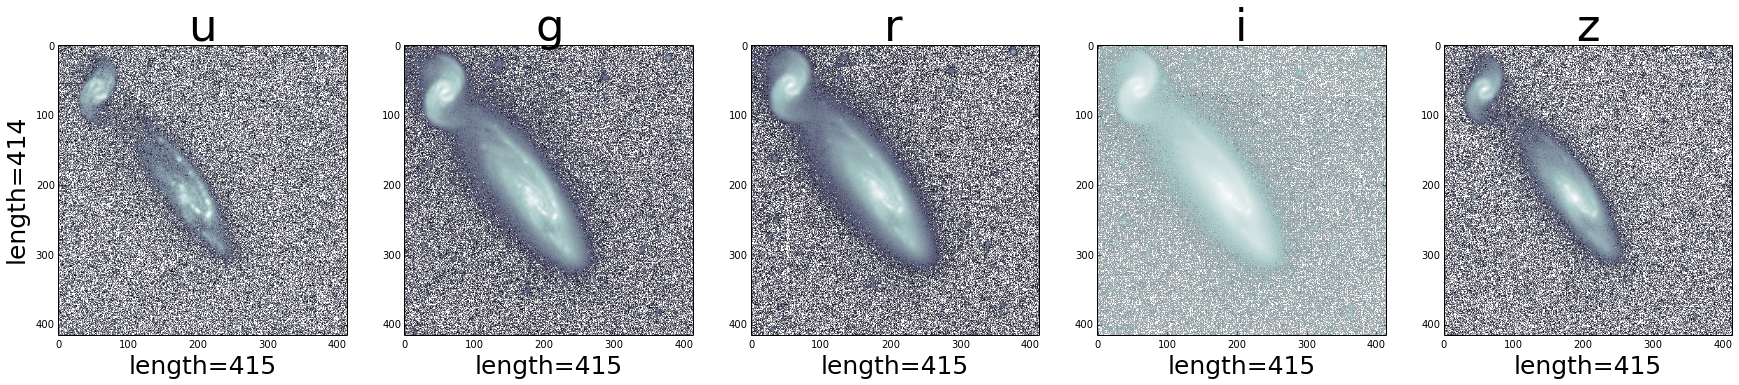

In [10]:

import matplotlib.gridspec as gridspec
f = plt.figure(figsize=(30,20))
gs = gridspec.GridSpec(1,5)
for i in range(0,5):
    ax = plt.subplot(gs[0,i])
    plt.imshow(cutouts[bands[i]].data,cmap=plt.cm.bone,norm=LogNorm())
    plt.title('%s'%bands[i],fontsize=45)
    plt.xlabel('length=%s'%cutouts[bands[i]].data.shape[0],fontsize=25)
    if i==0:
        plt.ylabel('length=%s'%cutouts[bands[i]].data.shape[1],fontsize=25)

In [14]:
cutouts['u'].data

array([[  6.5319438 ,  -4.52621126,   8.53767681, ...,   7.5969348 ,
         -8.53767681,  -4.49958658],
       [ -3.51890731,   2.51160336,  -2.51604104, ...,  -2.48497868,
         -1.47767484,  -0.46870691],
       [ -5.52907753,  11.55515099,  -7.54368544, ...,  -2.48497868,
          0.53970629,  -0.46870691],
       ..., 
       [  0.48701146,  -3.53221965,  13.56088352, ...,  -8.5465517 ,
          5.5645771 ,   9.60266781],
       [ -0.51807368,  -4.5395236 ,   0.48645678, ...,   2.54266572,
          0.52583927,   1.53536189],
       [ -4.5395236 ,   1.49098718,  -0.51862836, ...,  -6.5319438 ,
          1.53536189,  16.66710663]], dtype=float32)

In [39]:
for band in cutouts:
    name = 'fits_image_'+band+'.fits'
    cutouts[band].writeto(name,clobber=True)


## Zeropoints and Exposure Times

In [62]:
filename

'http://das.sdss.org/imaging/3631/40/calibChunks/5/tsField-003631-5-40-0388.fit'

In [67]:
tsf = fits.open('tsField-003631-5-40-0388.fit')

In [73]:
zeropoints = -1*tsf[1].data.aa

In [78]:
zeropoints[0]

array([ 24.03828812,  24.37540627,  24.0659771 ,  23.69671631,  22.39963913], dtype=float32)

In [7]:
exposure_time = []
for b in bands:
    exposure_time.append(float(hdulists[band][0].header['EXPTIME']))


In [8]:
exposure_time

[53.907456, 53.907456, 53.907456, 53.907456, 53.907456]

# SDSS PSF

In [81]:
psf_filename = 'https://data.sdss.org/sas/dr12/boss/photo/redux/'+'301'+'/'+run+'/objcs/'+camcol+'/psField-00'+run+'-'+camcol+'-0'+field+'.fit'
psf_filename

'https://data.sdss.org/sas/dr12/boss/photo/redux/301/3631/objcs/5/psField-003631-5-0388.fit'

In [82]:
sdss_psfs={}

sdss_psfs['u']=fits.open('u_psf.fit')
sdss_psfs['g']=fits.open('g_psf.fit')
sdss_psfs['r']=fits.open('r_psf.fit')
sdss_psfs['i']=fits.open('i_psf.fit')
sdss_psfs['z']=fits.open('z_psf.fit')

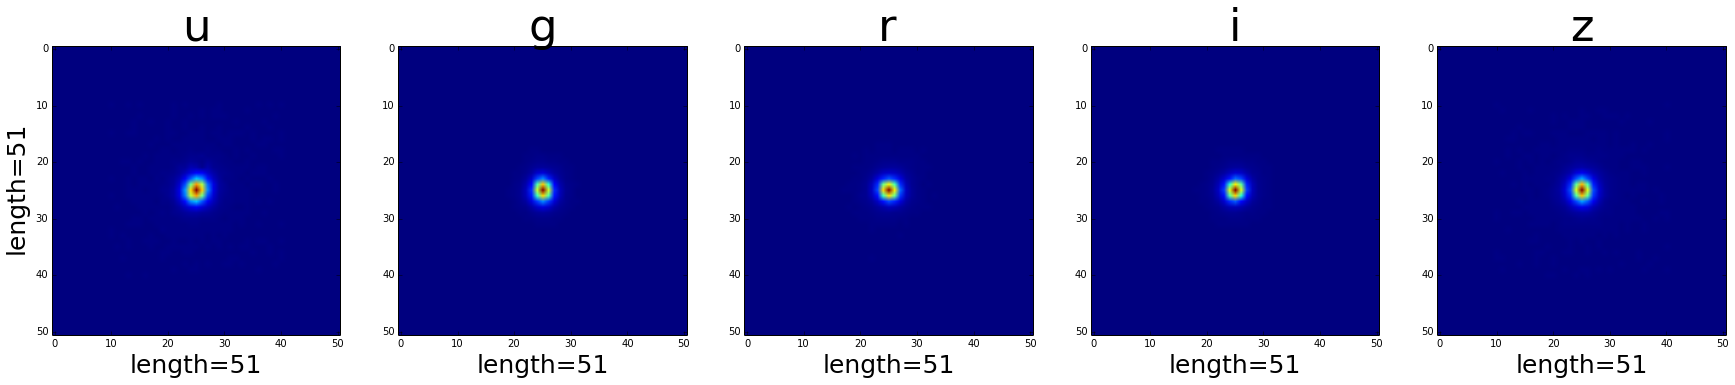

In [83]:
f = plt.figure(figsize=(30,15))
gs = gridspec.GridSpec(1,5)
for i in range(0,5):
    ax = plt.subplot(gs[0,i])
    plt.imshow(sdss_psfs[bands[i]][0].data)
    plt.title('%s'%bands[i],fontsize=45)
    plt.xlabel('length=%s'%sdss_psfs[bands[i]][0].data.shape[0],fontsize=25)
    if i==0:
        plt.ylabel('length=%s'%sdss_psfs[bands[i]][0].data.shape[1],fontsize=25)

## AEGIS PSF

In [8]:
psf_aegis = fits.open('../test_one_ferengi/aegis_psfi.fits')

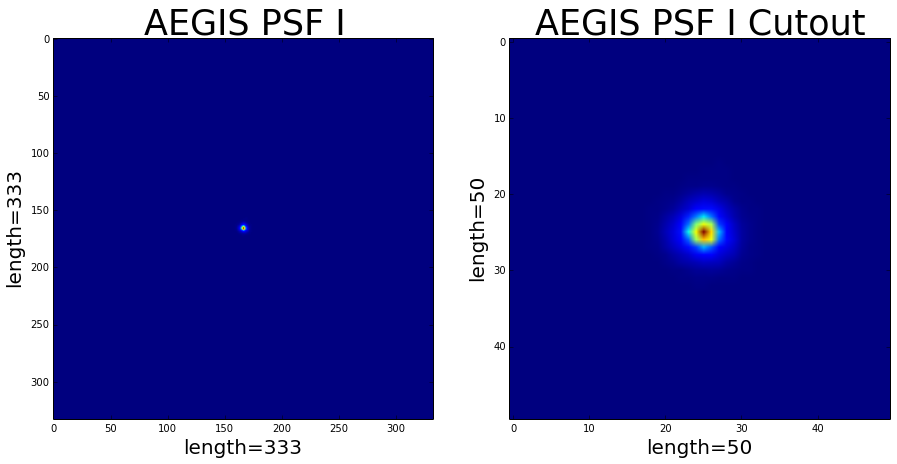

In [53]:
%matplotlib inline
f=plt.figure(figsize=(15,7))
gs=gridspec.GridSpec(1,2)
ax=plt.subplot(gs[0,0])
plt.imshow(psf_aegis[0].data)
plt.title('AEGIS PSF I',fontsize=35)
plt.xlabel('length=%s'%psf_aegis[0].data.shape[0],fontsize=20)
plt.ylabel('length=%s'%psf_aegis[0].data.shape[1],fontsize=20)
ax=plt.subplot(gs[0,1])
psf_cutout=psf_aegis[0].data[141:191,141:191]
plt.imshow(psf_cutout)
plt.title('AEGIS PSF I Cutout',fontsize=35)
plt.xlabel('length=%s'%psf_cutout.shape[0],fontsize=20)
plt.ylabel('length=%s'%psf_cutout.shape[1],fontsize=20)

In [11]:
psf_cutout=psf_aegis[0].data[141:191,141:191]
pc=fits.ImageHDU(data=psf_cutout)
pc.writeto('aegis_psfi_cutout.fits',clobber=True)

## Sky background image

In [6]:
scii = fits.open('../edited_blank_aegis_sky_i.fits')

In [7]:
scii[0].header

SIMPLE  =                    T /Primary Header created by MWRFITS v1.11         
BITPIX  =                  -32 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                 2001 /                                                
NAXIS2  =                 2001 /                                                
EXTEND  =                    T /Extensions may be present                       

<matplotlib.colorbar.Colorbar instance at 0x7f6a45747c20>

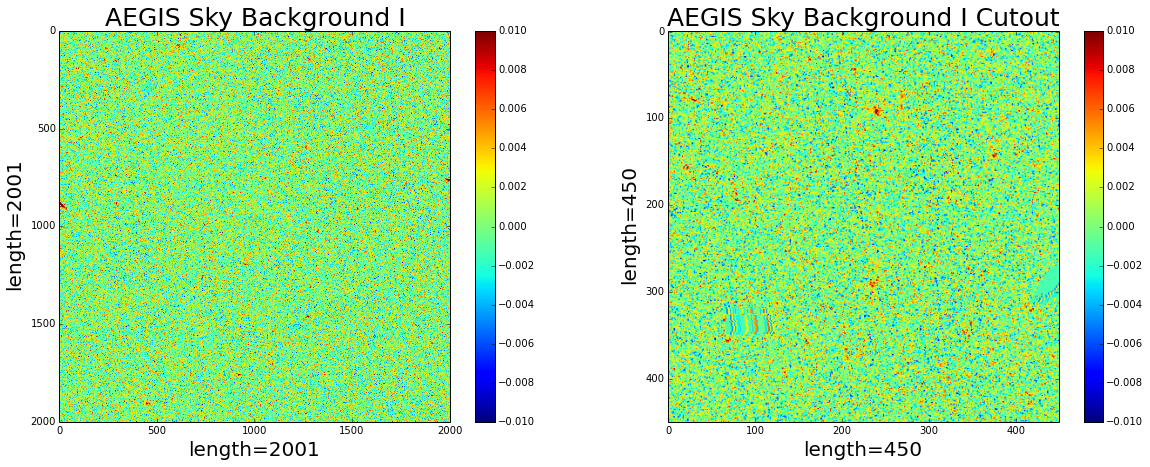

In [59]:
ski_cutout=scii[0].data[0:450,0:450]
f=plt.figure(figsize=(20,7))
gs=gridspec.GridSpec(1,2)
ax=plt.subplot(gs[0,0])
plt.imshow(scii[0].data,vmin=-.01,vmax=.01)
plt.title('AEGIS Sky Background I',fontsize=25)
plt.xlabel('length=%s'%scii[0].data.shape[0],fontsize=20)
plt.ylabel('length=%s'%scii[0].data.shape[1],fontsize=20)
plt.colorbar()
ax=plt.subplot(gs[0,1])
plt.imshow(ski_cutout,vmin=-.01,vmax=.01)
plt.title('AEGIS Sky Background I Cutout',fontsize=25)
plt.xlabel('length=%s'%ski_cutout.shape[0],fontsize=20)
plt.ylabel('length=%s'%ski_cutout.shape[1],fontsize=20)
plt.colorbar()

In [31]:
skic=fits.ImageHDU(data=ski_cutout)
skic.writeto('aegis_sky_cutout.fits',clobber=True)


# 1: No sky background, cutout AEGIS PSF

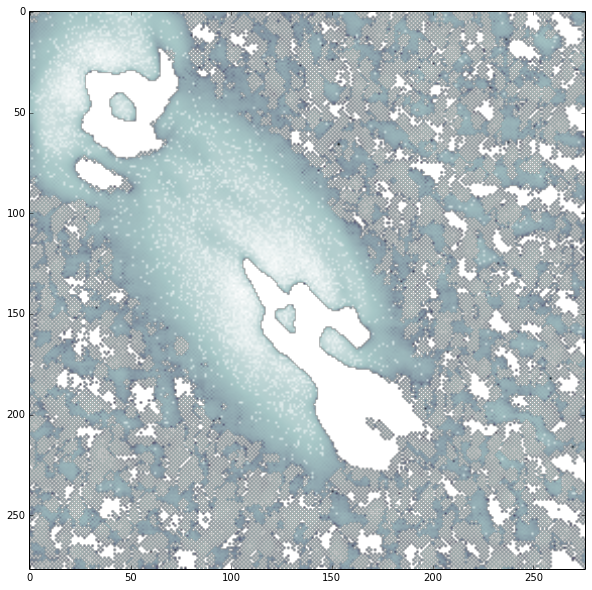

In [45]:
ferengi = fits.open('imout.fits')

f=plt.figure(figsize=(10,10))
plt.imshow(ferengi[0].data,norm=LogNorm(),cmap=plt.cm.bone)


# No Sky Background, full AEGIS PSF

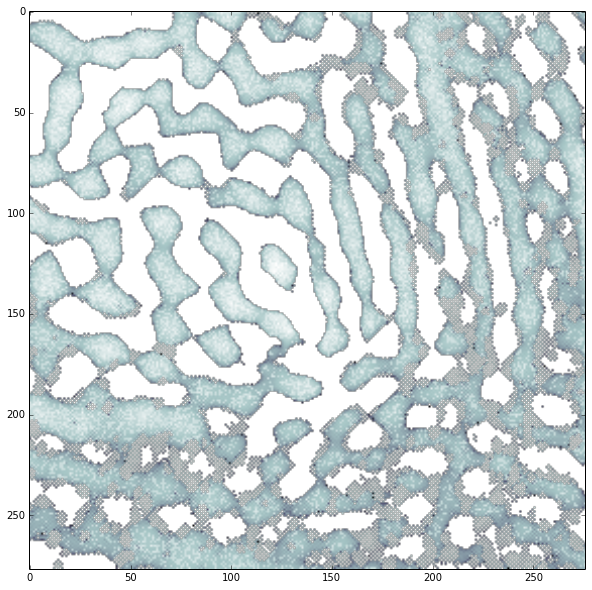

In [21]:
ferengi2 = fits.open('imout2.fits')

f=plt.figure(figsize=(10,10))
plt.imshow(ferengi2[0].data,norm=LogNorm(),cmap=plt.cm.bone)


# 3: AEGIS PSF cutout, Sky background cutout

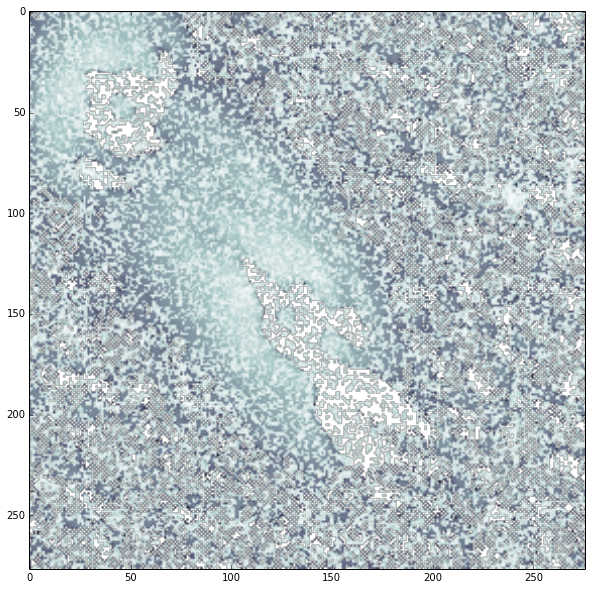

In [46]:
ferengi3 = fits.open('imout3.fits')

f=plt.figure(figsize=(10,10))
plt.imshow(ferengi3[0].data,norm=LogNorm(),cmap=plt.cm.bone)


# 4. PSF cutout, full sky background

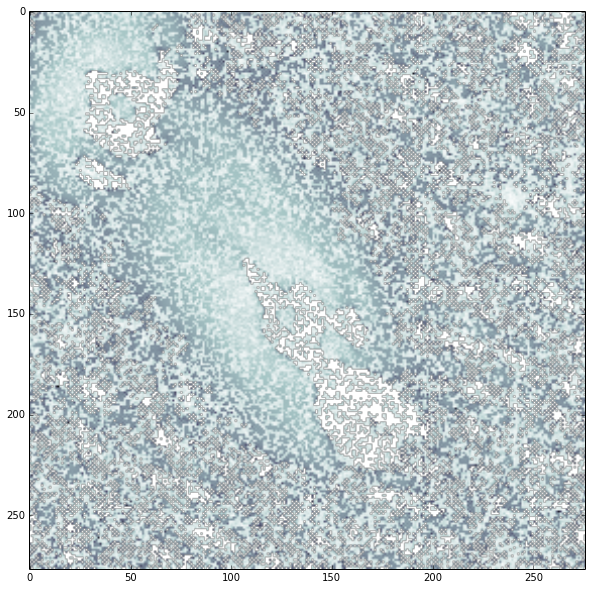

In [47]:
ferengi4 = fits.open('imout4.fits')

f=plt.figure(figsize=(10,10))
plt.imshow(ferengi4[0].data,norm=LogNorm(),cmap=plt.cm.bone)


# Results:

## Using cutout PSF is required - but should it be scaled down to size instead of a straight cutout? 

## Size of sky background seems to make no difference, but seems to overpower image still. 

# 5. FERENGI TEST code

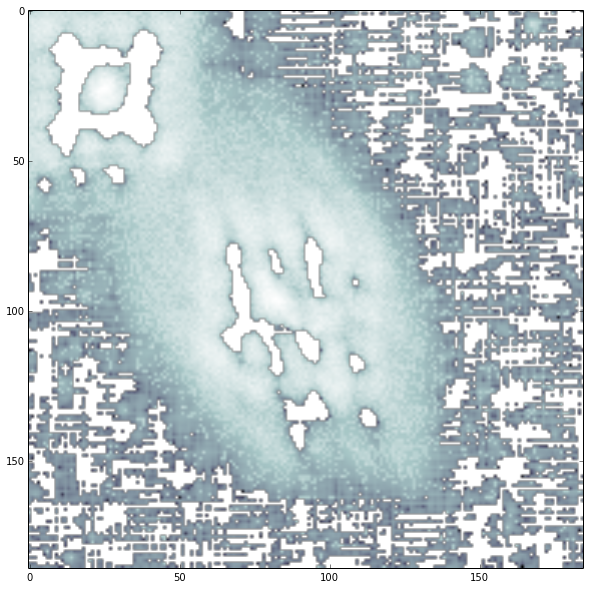

In [6]:
ferengis = fits.open('imout_sdss.fits')

f=plt.figure(figsize=(10,10))
plt.imshow(ferengis[0].data,norm=LogNorm(),cmap=plt.cm.bone)

# 6. FERENGI TEST code, with correct units (counts instead of nmgy)

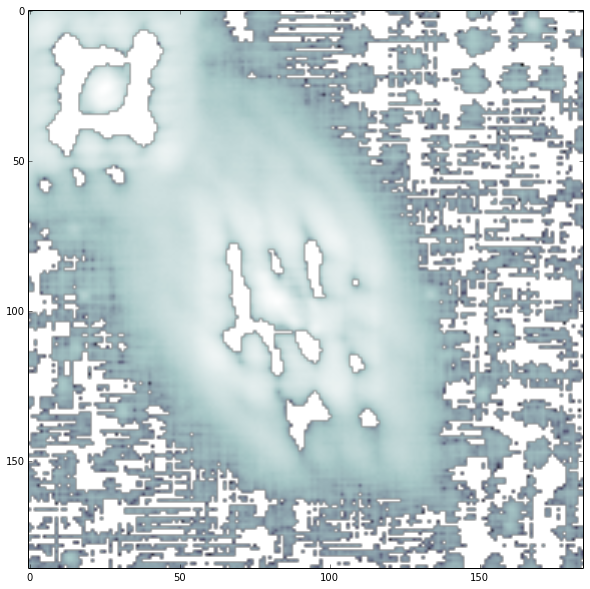

In [4]:
ferengis_le = fits.open('imout_sdss_converted.fits')

f=plt.figure(figsize=(10,10))
plt.imshow(ferengis_le[0].data,norm=LogNorm(),cmap=plt.cm.bone)

# 7. Full AEGIS PSF, no background, correct units (counts) for images

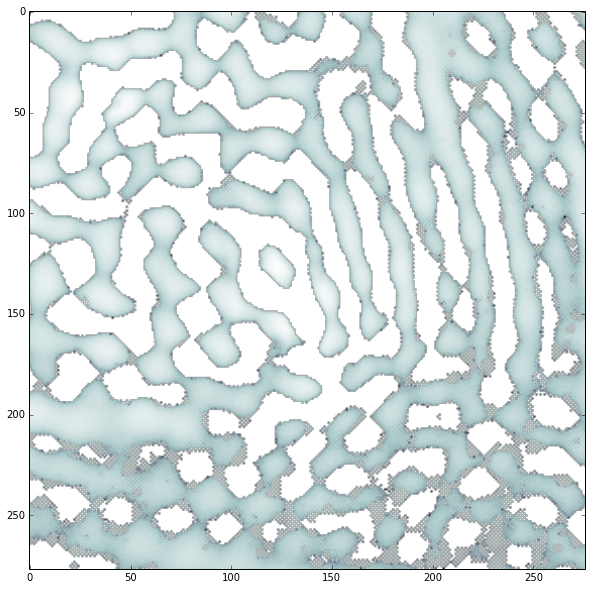

In [9]:
ferengis_ac = fits.open('imout_aegis_converted.fits')

f=plt.figure(figsize=(10,10))
plt.imshow(ferengis_ac[0].data,norm=LogNorm(),cmap=plt.cm.bone)